# Number density and bias with real data

In [35]:
import os, sys
sys.path.append('../')
from xd import *
from run_DMASS import *
from utils import *
import esutil
import healpy as hp
from systematics import *
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### Calling Gold mask and calculating map area

In [36]:
# calling map 
GoldMask = callingEliGoldMask()
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ GoldMask['DEC'] > -3.0 ]
GoldMask_spt = GoldMask[ GoldMask['DEC'] < -3.0 ]
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

In [ ]:
spatialcheck([gold_st82])

In [4]:
rootdir = '../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5_baomask/'

In [5]:
# calling BOSS cmass and applying dmass goodregion mask ----------------------------
#cmass = io.getSGCCMASSphotoObjcat()
train_sample = esutil.io.read('../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5_baomask/train_sample_des.fits')
print 'total num of train', train_sample.size
print '\n--------------------------------\n applying DES veto mask to CMASS\n--------------------------------'   
#train_sample = Cuts.keepGoodRegion(train_sample)

total num of train 11590

--------------------------------
 applying DES veto mask to CMASS
--------------------------------


In [6]:
gold_st82 = io.SearchAndCallFits(path = '/n/des/lee.5922/data/gold_cat/', columns = None, keyword = 'Y1A1_GOLD_STRIPE82_v2')
gold_st82 = gold_st82[(gold_st82['MODEST_CLASS'] == 1)&(gold_st82['FLAGS_GOLD'] == 0 )]
gold_st82 = Cuts.keepGoodRegion(gold_st82)

gold_st82 = RemovingSLRReddening(gold_st82)
gold_st82 = AddingSFD98Reddening(gold_st82, kind='STRIPE82')

# flags and color cut
mask_all = priorCut_test(gold_st82)
gold_st82 = gold_st82[mask_all]


--------------------------------
 calling catalog
--------------------------------
Y1A1_GOLD_STRIPE82_v2_000001.fits
Y1A1_GOLD_STRIPE82_v2_000002.fits
Y1A1_GOLD_STRIPE82_v2_000003.fits
Y1A1_GOLD_STRIPE82_v2_000004.fits
Y1A1_GOLD_STRIPE82_v2_000005.fits
Y1A1_GOLD_STRIPE82_v2_000006.fits
Y1A1_GOLD_STRIPE82_v2_000007.fits
Y1A1_GOLD_STRIPE82_v2_000008.fits
reading 1/8 /n/des/lee.5922/data/gold_cat/Y1A1_GOLD_STRIPE82_v2_000001.fits
reading 2/8 /n/des/lee.5922/data/gold_cat/Y1A1_GOLD_STRIPE82_v2_000002.fits
reading 3/8 /n/des/lee.5922/data/gold_cat/Y1A1_GOLD_STRIPE82_v2_000003.fits
reading 4/8 /n/des/lee.5922/data/gold_cat/Y1A1_GOLD_STRIPE82_v2_000004.fits
reading 5/8 /n/des/lee.5922/data/gold_cat/Y1A1_GOLD_STRIPE82_v2_000005.fits
reading 6/8 /n/des/lee.5922/data/gold_cat/Y1A1_GOLD_STRIPE82_v2_000006.fits
reading 7/8 /n/des/lee.5922/data/gold_cat/Y1A1_GOLD_STRIPE82_v2_000007.fits
reading 8/8 /n/des/lee.5922/data/gold_cat/Y1A1_GOLD_STRIPE82_v2_000008.fits
Removing SLR Shift 
  removing SLR f

figsave : .//spatialtest_.png


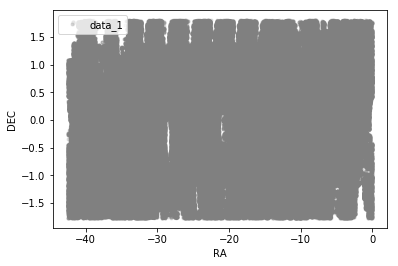

In [8]:
spatialcheck([gold_st82])

In [14]:
np.sum([gold_st82['RA'].min(), gold_st82['RA'].max()])/2.

338.74188649999996

In [156]:
healConfig={}
healConfig['out_nside'] = 64

In [197]:
train_sample = HealPixifyCatalogs(catalog=train_sample, healConfig=healConfig, ratag='RA', dectag = 'DEC')
gold_st82 = HealPixifyCatalogs(catalog=gold_st82, healConfig=healConfig, ratag='RA', dectag = 'DEC')

In [20]:
evenmask_train = train_sample['RA'] > 339
evenmask = gold_st82['RA'] > 339

In [21]:
train_even = train_sample[evenmask_train]
train_odd = train_sample[~evenmask_train]
gold_st82_even = gold_st82[evenmask]
gold_st82_odd = gold_st82[~evenmask]

In [22]:
train_even.size, train_odd.size

(5776, 5814)

In [25]:
fitsio.write('../output/st82_halfhalf_numdensity_spatial/gold_st82_highra.fits', gold_st82_even, clobber=True)
fitsio.write('../output/st82_halfhalf_numdensity_spatial/gold_st82_lowra.fits', gold_st82_odd, clobber=True)

In [84]:
#rootdir2 = '../output/sfd_train_photo_SamPle_nozband_ran10_restore/'
#fitsio.write(rootdir2 + 'gold_st82_prob.fits', gold_st82)

In [26]:
mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82['RA'], \
                                     gold_st82['DEC'],2./3600, maxmatch=1)
cmass_mask = np.zeros(gold_st82.size, dtype=bool)
cmass_mask[mg2] = 1
clean_cmass_data_des, nocmass = gold_st82[cmass_mask], gold_st82[~cmass_mask]
print 'cmass_fraction even', clean_cmass_data_des.size *1./gold_st82.size
fraction_even = clean_cmass_data_des.size *1./gold_st82.size

cmass_fraction even 0.0182077537696


In [191]:
clean_cmass_data_des.size

11590

In [34]:
gold_st82_even.size, gold_st82_odd.size

(307731, 328811)

In [27]:
mg1, mg2, _ = esutil.htm.HTM(10).match(train_even['RA'], train_even['DEC'], gold_st82_even['RA'], \
                                     gold_st82_even['DEC'],2./3600, maxmatch=1)
cmass_mask_even = np.zeros(gold_st82_even.size, dtype=bool)
cmass_mask_even[mg2] = 1
clean_cmass_data_des_even, nocmass_even = gold_st82_even[cmass_mask_even], gold_st82_even[~cmass_mask_even]
print 'cmass_fraction even', clean_cmass_data_des_even.size *1./gold_st82_even.size
fraction_even = clean_cmass_data_des_even.size *1./gold_st82_even.size

cmass_fraction even 0.0187696397178


In [28]:
mg1, mg2, _ = esutil.htm.HTM(10).match(train_odd['RA'], train_odd['DEC'], gold_st82_odd['RA'], \
                                     gold_st82_odd['DEC'],2./3600, maxmatch=1)
cmass_mask_odd = np.zeros(gold_st82_odd.size, dtype=bool)
cmass_mask_odd[mg2] = 1
clean_cmass_data_des_odd, nocmass_odd = gold_st82_odd[cmass_mask_odd], gold_st82_odd[~cmass_mask_odd]
print 'cmass_fraction odd', clean_cmass_data_des_odd.size *1./gold_st82_odd.size
fraction_odd = clean_cmass_data_des_odd.size *1./gold_st82_odd.size

cmass_fraction odd 0.0176818902044


# Fitting 

In [30]:
cmass_pickle = '../output/st82_halfhalf_numdensity_spatial//gold_st82_XD_cmass_highra.pkl'
init_cmass_pickle = '../output/sfd_train_photo_SamPle_nozband_ran10_3/gold_st82_XD_cmass.pkl'
clf_cmass_st82 = XD_fitting( data = clean_cmass_data_des_even, pickleFileName = cmass_pickle , init_params = init_cmass_pickle, 
                    n_cl = 10, n_iter = 2000, tol = 1e-5, verbose = True)

No z_band!
@pickle_results: computing results and saving to '../output/st82_halfhalf_numdensity_spatial//gold_st82_XD_cmass_highra.pkl'
init_params = True : initializing with cmass params 
n components = 8
tolerance = 1e-05
1: log(L) = 13205.11376
    (4.3 sec)
2: log(L) = 13205.26756
    (4.5 sec)
3: log(L) = 13205.45503
    (4.7 sec)
4: log(L) = 13205.60041
    (4.9 sec)
5: log(L) = 13205.69811
    (4.6 sec)
6: log(L) = 13205.76129
    (4.7 sec)
7: log(L) = 13205.80203
    (4.4 sec)
8: log(L) = 13205.82861
    (4.5 sec)
9: log(L) = 13205.84625
    (4.8 sec)
10: log(L) = 13205.85818
    (4.5 sec)
11: log(L) = 13205.86642
    (4.8 sec)
12: log(L) = 13205.87223
    (4.8 sec)
13: log(L) = 13205.87641
    (4.5 sec)
14: log(L) = 13205.87947
    (4.7 sec)
15: log(L) = 13205.88176
    (4.9 sec)
16: log(L) = 13205.88348
    (5 sec)
17: log(L) = 13205.88481
    (4.5 sec)
18: log(L) = 13205.88583
    (4.5 sec)
19: log(L) = 13205.88663
    (4.5 sec)
20: log(L) = 13205.88726
    (4.8 sec)
21: log

In [31]:
cmass_pickle = '../output/st82_halfhalf_numdensity_spatial//gold_st82_XD_cmass_lowra.pkl'
init_cmass_pickle = '../output/sfd_train_photo_SamPle_nozband_ran10_3/gold_st82_XD_cmass.pkl'
clf_cmass_st82 = XD_fitting( data = clean_cmass_data_des_odd, pickleFileName = cmass_pickle , init_params = init_cmass_pickle, 
                    n_cl = 10, n_iter = 2000, tol = 1e-5, verbose = True)

No z_band!
@pickle_results: computing results and saving to '../output/st82_halfhalf_numdensity_spatial//gold_st82_XD_cmass_lowra.pkl'
init_params = True : initializing with cmass params 
n components = 8
tolerance = 1e-05
1: log(L) = 12691.84654
    (4.5 sec)
2: log(L) = 12692.06921
    (4.8 sec)
3: log(L) = 12692.23945
    (4.7 sec)
4: log(L) = 12692.3562
    (4.7 sec)
5: log(L) = 12692.42584
    (4.6 sec)
6: log(L) = 12692.46197
    (4.8 sec)
7: log(L) = 12692.47675
    (4.7 sec)
8: log(L) = 12692.47888
    (4.8 sec)
9: log(L) = 12692.47407
    (4.7 sec)
elapsed time: 0.62 min,  total iteration 8                                 


In [32]:
no_pickle = '../output/st82_halfhalf_numdensity_spatial//gold_st82_XD_no_highra.pkl'
init_pickle = '../output/sfd_train_photo_SamPle_nozband_ran10_3/gold_st82_XD_no.pkl'
clf_no_st82 = XD_fitting( data = nocmass_even, pickleFileName = no_pickle , init_params = init_pickle, 
                    n_cl = 10, n_iter = 5000, tol = 1e-5, verbose = True)

No z_band!
@pickle_results: computing results and saving to '../output/st82_halfhalf_numdensity_spatial//gold_st82_XD_no_highra.pkl'
init_params = True : initializing with cmass params 
n components = 26
tolerance = 1e-05
1: log(L) = 327450.0284
    (1.9e+02 sec)
2: log(L) = 327457.2476
    (1.9e+02 sec)
3: log(L) = 327459.6415
    (1.9e+02 sec)
4: log(L) = 327461.2988
    (1.9e+02 sec)
5: log(L) = 327462.4052
    (1.8e+02 sec)
6: log(L) = 327463.0681
    (1.8e+02 sec)
7: log(L) = 327463.4183
    (1.9e+02 sec)
8: log(L) = 327463.5652
    (1.9e+02 sec)
9: log(L) = 327463.5877
    (1.9e+02 sec)
10: log(L) = 327463.5385
    (1.9e+02 sec)
elapsed time: 28.61 min,  total iteration 9                                 


In [33]:
no_pickle = '../output/st82_halfhalf_numdensity_spatial//gold_st82_XD_no_lowra.pkl'
init_pickle = '../output/sfd_train_photo_SamPle_nozband_ran10_3/gold_st82_XD_no.pkl'
clf_no_st82 = XD_fitting( data = nocmass_odd, pickleFileName = no_pickle , init_params = init_pickle, 
                    n_cl = 10, n_iter = 5000, tol = 1e-5, verbose = True)

No z_band!
@pickle_results: computing results and saving to '../output/st82_halfhalf_numdensity_spatial//gold_st82_XD_no_lowra.pkl'
init_params = True : initializing with cmass params 
n components = 26
tolerance = 1e-05
1: log(L) = 341240.195
    (2e+02 sec)
2: log(L) = 341248.7798
    (2.2e+02 sec)
3: log(L) = 341250.6123
    (2.6e+02 sec)
4: log(L) = 341251.4832
    (2.5e+02 sec)
5: log(L) = 341251.6303
    (2e+02 sec)
6: log(L) = 341251.2744
    (2e+02 sec)
elapsed time: 16.41 min,  total iteration 5                                 


KeyboardInterrupt: 

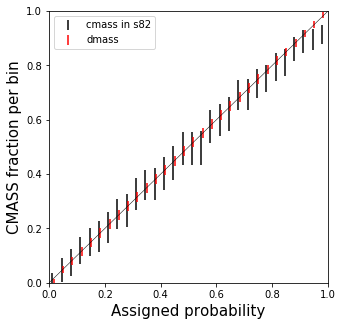

In [179]:
bins, step = np.linspace(0, 1.0, 31, retstep = True)
Ngal_cmass, _ = np.histogram( clean_cmass_data_des['EachProb_CMASS'], bins=bins )
Ngal_all, _ = np.histogram( gold_st82['EachProb_CMASS'], bins=bins )
ngal = Ngal_cmass * 1./Ngal_all
err = 1./np.sqrt(Ngal_cmass) #* ngal


Ngal_dmass_spt, _ = np.histogram( gold_spt['EachProb_CMASS'], bins=bins , weights=gold_spt['EachProb_CMASS'])
Ngal_all_spt, _ = np.histogram( gold_spt['EachProb_CMASS'], bins=bins )
ngal_spt = Ngal_dmass_spt * 1./Ngal_all_spt
err_spt = 1./np.sqrt(Ngal_dmass_spt)# * ngal_spt


fig, ax = plt.subplots(figsize = (5,5))

ax.errorbar( bins[:-1] + step/2.-0.005, ngal, yerr = err, fmt='none', color = 'k', alpha = 1, label='cmass in s82' )
ax.errorbar( bins[:-1] + step/2., ngal_spt, yerr = err_spt, fmt='none', color = 'r', alpha = 1, label = 'dmass' )

ax.plot([0,1], [0,1], '-', lw = 0.5, color = 'k')
ax.set_ylim(0,1)
ax.set_xlim(0,1)
ax.set_xlabel('Assigned probability', fontsize = 15)
ax.set_ylabel('CMASS fraction per bin', fontsize = 15)
ax.legend(loc='best')

fig.savefig('../paper_figure/model_prob.pdf')

## Density vs maglimit

In [12]:
# apply basic Cuts to maglim map
path = '/n/des/lee.5922/data/balrog_cat/'
goodmask = path+'y1a1_gold_1.0.2_wide_footprint_4096.fit'
badmask = path+'y1a1_gold_1.0.2_wide_badmask_4096.fit'
fraction = hp.read_map(path+'Y1A1_WIDE_frac_combined_griz_o.4096_t.32768_EQU.fits')

# Note that the masks here in in equatorial, ring format.
gdmask = hp.read_map(goodmask)
bdmask = hp.read_map(badmask)

ind_good_ring = np.where(( gdmask >= 1)
                         & ((bdmask.astype('int64') & (64+32+8)) == 0)
                         & (fraction > 0.8)
                         )

goldmask = np.zeros(gdmask.size, dtype=bool)
goldmask[ind_good_ring] = 1

path = '/n/des/lee.5922/data/systematic_maps/'
maglim_i = hp.read_map(path+'y1a1_gold_1.0.2_wide_auto_nside4096_i_10sigma.fits')
maglim_i[~goldmask] = hp.UNSEEN

NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [3]:
# calling data w/o cuts
#des_gold_st82_list = []
des_gold_spt1_list = []
#des_gold_spt2_list = []
for i in range(3):
    des_gold = io.getDESY1A1catalogs(keyword = 'merged_'+str(i), gold=True)
    #des_gold_st82 = Cuts.SpatialCuts(des_gold, ra=320, ra2=360, dec = -2, dec2 = 2)
    des_gold_spt1 = Cuts.SpatialCuts(des_gold, ra=0, ra2=100, dec = -48, dec2 = -44)
    #des_gold_spt2 = Cuts.SpatialCuts(des_gold, ra=50, ra2=100, dec = -52, dec2 = -48)
    #des_gold_st82_list.append(des_gold_st82)
    des_gold_spt1_list.append(des_gold_spt1)
    #des_gold_spt2_list.append(des_gold_spt2)
    des_gold = None
"""
des_gold_st82_list = np.hstack(des_gold_st82_list)
mags = ['MAG_MODEL', 'MAG_DETMODEL', 'MAG_AUTO', 'MAG_APER_3', 'MAG_APER_4', 'MAG_APER_5', 'MAG_APER_6']
des_gold_st82_list = getCorrectedMag( des_gold_st82_list, mags = mags, reddening = None )
fitsio.write('result_cat/merged_des_st82_nocut.fits', des_gold_st82_list, clobber = True)
"""
des_gold_spt1_list = np.hstack(des_gold_spt1_list)
mags = ['MAG_MODEL', 'MAG_DETMODEL', 'MAG_AUTO', 'MAG_APER_3', 'MAG_APER_4', 'MAG_APER_5', 'MAG_APER_6']
des_gold_spt1_list = getCorrectedMag( des_gold_spt1_list, mags = mags, reddening = None )
fitsio.write('result_cat/merged_des_spt_nocut.fits', des_gold_spt1_list, clobber = True)

Y1A1_GOLD_merged_01.fits
Y1A1_GOLD_merged_02.fits
Y1A1_GOLD_merged_03.fits
Y1A1_GOLD_merged_04.fits
Y1A1_GOLD_merged_05.fits
Y1A1_GOLD_merged_06.fits
Y1A1_GOLD_merged_07.fits
Y1A1_GOLD_merged_08.fits
Y1A1_GOLD_merged_09.fits
Spatial Cut  4970916
Spatial Cut  11313779
Y1A1_GOLD_merged_10.fits
Y1A1_GOLD_merged_11.fits
Y1A1_GOLD_merged_12.fits
Y1A1_GOLD_merged_13.fits
Y1A1_GOLD_merged_14.fits
Y1A1_GOLD_merged_15.fits
Y1A1_GOLD_merged_16.fits
Y1A1_GOLD_merged_17.fits
Y1A1_GOLD_merged_18.fits
Y1A1_GOLD_merged_19.fits
Spatial Cut  2665556
Spatial Cut  2269240
Y1A1_GOLD_merged_20.fits
Spatial Cut  216904
Spatial Cut  311760


In [160]:
def CalculateOverdensity(des, maglim_i, nside = 512):
    # maglim should be masked in advance
    
    maglim_i_256 = hp.ud_grade(maglim_i, nside_out = nside, pess=True)
    bdmask = maglim_i_256 > 0
    mapInd = np.arange(maglim_i_256.size)[bdmask] 
    buzInd = hpRaDecToHEALPixel( des['RA'], des['DEC'],nside=nside)
    
    
    
    # combine array
    maglim_i_com = np.zeros((maglim_i_256[bdmask].size,), \
                            dtype=[('pix', 'int'),('sig', 'float')])                        
    maglim_i_com['pix'] = mapInd
    maglim_i_com['sig'] = maglim_i_256[bdmask]
    
    
    MM = np.in1d(mapInd, buzInd)
    maglim_i_com = maglim_i_com[MM]
    
    r, d = hpHEALPixelToRaDec(maglim_i_com['pix'], nside = nside)
    fig, ax = plt.subplots()
    ax.plot(r, d, '.')
    
    
    N = []
    for i in range(maglim_i_com.size):
        n = np.sum(buzInd == maglim_i_com['pix'][i])
        N.append(n)
    N = np.array(N)
    
    Apix256 = hp.nside2pixarea( nside, degrees = True)
    n256 = (N/Apix256) #[effectivemask]
    #mapIndinbuz_mask = np.in1d(mapInd, buzInd)
    #Atot = np.sum(bdmask) * Apix256
    #ntot = des.size/Atot
    ntot = np.mean(n256)
    overdensity = (n256/ntot)
    
    bin_mag, s = np.linspace(21.8, 23, 20, retstep=True)
    #bin_mag = #bin_mag + s/2.
    mag_ind = np.digitize(maglim_i_com['sig'], bins = bin_mag)
    avg_overdensity = []
    error_over = []
    for i in range(bin_mag.size):
        ma = mag_ind == i
        avg = np.mean(overdensity[ma])
        avg_overdensity.append(avg)
        Nt = np.sum(N[ma])
        #print np.std(overdensity[ma])
        err = np.std(overdensity[ma]) /np.sqrt(np.sum(ma))
        error_over.append(err)
        
    return np.array(bin_mag), np.array(avg_overdensity), np.array(error_over)

In [66]:
# masking maglim map within stripe82 region
mapInd = np.arange(maglim_i.size)
r, d = hpHEALPixelToRaDec(mapInd, nside = 4096)
mask = (r > 320)&(r < 360) & (d >-2)&(d<2)
maglim_i_st82 = maglim_i.copy()
maglim_i_st82[~mask] = hp.UNSEEN

# masking maglim map within spt region
mask_spt = (r > 0)&(r < 100) & (d >-52)&(d<-48)
maglim_i_spt = maglim_i.copy()
maglim_i_spt[~mask_spt] = hp.UNSEEN

nan
0.0614206832197
0.103998208837
0.114463079785
0.127525798663
0.118901595
0.117321217773
0.133722649768
0.129317375319
0.131427133839
0.12127907391
0.131729675726
0.131255439806
0.136870884207
0.135309326023
0.125617853857
0.158645248827
0.128205488922
0.0927554997303
0.0822501367118


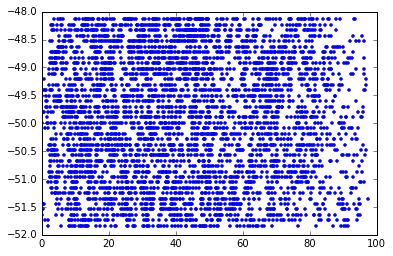

In [158]:
bin_mag, avg_overdensity, error_over = CalculateOverdensity(merged_des_st82, maglim_i_st82, nside = 512)
bin_mag2, avg_overdensity2, error_over2 = CalculateOverdensity(merged_des_patch, maglim_i_spt, nside = 512)

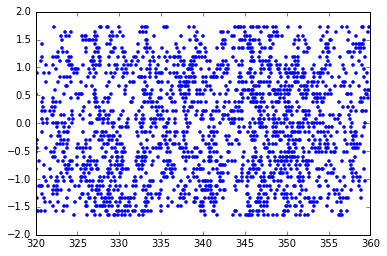

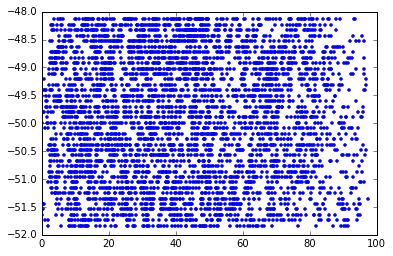

In [165]:
merged_des_st82_2 = merged_des_st82[merged_des_st82['MAG_AUTO_I_corrected']<= 21]
merged_des_patch_2 = merged_des_patch[merged_des_patch['MAG_AUTO_I_corrected']<= 21]
bin_mag3, avg_overdensity3, error_over3 = CalculateOverdensity(merged_des_st82_2, maglim_i_st82, nside = 512)
bin_mag4, avg_overdensity4, error_over4 = CalculateOverdensity(merged_des_patch_2, maglim_i_spt, nside = 512)

In [168]:
def chisquare_test(avg_overdensity, error_over):

    avg_overdensity = np.array(avg_overdensity)
    error_over = np.array(error_over)
    mask = np.ma.masked_invalid(avg_overdensity)
    #mask2 = np.ma.masked_invalid(error_over)
    m = ((~mask.mask) & (error_over != 0))
    #m2 = ~mask2.mask
    galaxy_density = avg_overdensity[m]
    err = error_over[m]
    bin = bin_mag[m]
    chisquare = np.sum((galaxy_density - 1.0)**2/err**2 )
    return chisquare/np.sum(m)

In [169]:
chi1 = chisquare_test(avg_overdensity, error_over)
chi2 = chisquare_test(avg_overdensity2, error_over2)

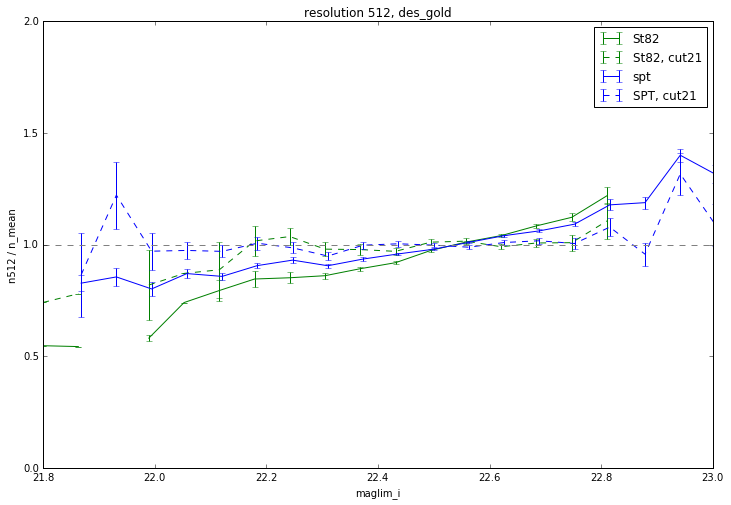

In [166]:
fig, ax = plt.subplots(1,1, figsize = (12, 8))
#ax.plot(maglim_i_256[bdmask][zeromask], overdensity, '.')
#ax.plot(bin_mag, avg_overdensity, '.')
ax.errorbar(bin_mag, avg_overdensity, yerr = error_over, color = 'green', label = 'St82')
ax.errorbar(bin_mag3, avg_overdensity3, yerr = error_over3, color = 'green', linestyle = '--', label = 'St82, cut21')
ax.errorbar(bin_mag2 + 0.005, avg_overdensity2, yerr = error_over2, color = 'blue', label = 'spt')
ax.errorbar(bin_mag4 + 0.005, avg_overdensity4, yerr = error_over4, color = 'blue', linestyle='--',label='SPT, cut21')
ax.axhline(y=1, color='grey', linestyle='--')
ax.set_xlabel('maglim_i')
ax.set_ylabel('n512 / n_mean')
ax.set_title('resolution 512, des_gold')
ax.set_ylim(0,2)
ax.set_xlim(21.8, 23)
ax.legend(loc='best')

## Density comparison in SPT and stripe82